Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

###  Описание данных
<b> <i> Признаки </i> </b> <br>
<b>DateCrawled</b> — дата скачивания анкеты из базы<br>
<b>VehicleType</b> — тип автомобильного кузова<br>
<b>RegistrationYear</b> — год регистрации автомобиля<br>
<b>Gearbox</b> — тип коробки передач<br>
<b>Power</b> — мощность (л. с.)<br>
<b>Model</b> — модель автомобиля<br>
<b>Kilometer</b> — пробег (км)<br>
<b>RegistrationMont</b> — месяц регистрации автомобиля<br>
<b>FuelType</b> — тип топлива<br>
<b>Brand</b> — марка автомобиля<br>
<b>NotRepaired</b> — была машина в ремонте или нет<br>
<b>DateCreated</b> — дата создания анкеты<br>
<b>NumberOfPictures</b> — количество фотографий автомобиля<br>
<b>PostalCode</b> — почтовый индекс владельца анкеты (пользователя)<br>
<b>LastSeen</b> — дата последней активности пользователя<br>

<b> <i> Целевой признак </i> </b> <br>
<b>Price</b> — цена (евро)<br>

# Оглавление
1. [Загрузка данных и изучение общей информации](#step1)
2. [Подготовка данных](#step2)
    * [Поиск аномальных значений](#step2_1) 
    * [Обработка пропусков](#step2_2)
    * [Создание обучающей и тестовой выборки](#step2_3)
3. [Обучение моделей](#step3)
4. [Анализ моделей](#step4)
5. [Общий вывод](#step5)

<div align='justify'> <i> Загружаем необходимые библиотеки и настраиваем Jupyter.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy
import math
import matplotlib.pyplot as plt
import sklearn
import catboost
import lightgbm as lgb

from platform import python_version
from datetime import datetime

from IPython.display import display
import warnings
warnings.simplefilter(action = 'ignore', category = RuntimeWarning)
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from scipy import stats as st

/opt/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<div align='justify'> <i> Информация о версиях используемых библиотек.

In [2]:
current_date = datetime.now().strftime("%Y.%m.%d")
print(f'Date: {current_date}')
print(f'Python version: {python_version()}')
print (f'Pandas version: {pd.__version__}')
print (f'Seaborn version: {sns.__version__}')
print (f'Numpy version: {np.__version__}')
print (f'Scipy version: {scipy.__version__}')
print (f'Sklearn version: {sklearn.__version__}')
print (f'CatBoost version: {catboost.__version__}')
print (f'LightGBM version: {lgb.__version__}')

Date: 2020.07.16
Python version: 3.7.6
Pandas version: 1.0.5
Seaborn version: 0.9.0
Numpy version: 1.19.0
Scipy version: 1.4.1
Sklearn version: 0.21.2
CatBoost version: 0.20.2
LightGBM version: 2.3.1


<div align="justify"> <i> Задаем константы и пишем функции, которые будем использовать многократно на протяжении всего проекта.

In [3]:
# начальное состояние для моделей
RANDOM_STATE = 12345

# цвета и палетка для графиков
COLOR = '#a52a2a'
COLOR_LINE = '#e29072'
PALETTE='rocket'

# функция расчета интервала вывода для гистограмм
# column - колонка с набором данных
# coeff - коэффициент при интерквартильном размахе
def get_range(column, coeff):
    iqr = column.quantile(0.75)-column.quantile(0.25)
    low = column.quantile(0.25)-coeff*iqr
    high = column.quantile(0.75)+coeff*iqr
    interval = (low, high)
    return interval

# 1. Загрузка данных и изучение общей информации <a name="step1"></a>

<div align="justify"> <i> Загрузим исторические данные: технические характеристики, комплектации и цены автомобилей, полученные от сервиса по продаже автомобилей с пробегом «Не бит, не крашен».

In [4]:
autos = pd.read_csv('/datasets/autos.csv')

<div align="justify"> <i> Изучим загруженные данные. <br>

In [5]:
display(autos.info())
display(autos.head())
display(autos.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


### Вывод

<div style = "border:solid #a1b5c9 2px; padding: 20px; background: #f0f0f0" align="justify">Рассмотрев исходные данные можно сделать следующие выводы:<br>
1. В столбцах 'VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired' имеются пропуски. Необходимо проанализировать и при необходимотси обработать их. <br>
2. В таблице есть столбцы с датами 'DateCrawled', 'DateCreated', 'LastSeen'. Значения в этих столбцах не соответствуют форматам данных, записанных в них.<br>
3. В столбце 'NumberOfPictures' только нулевые значения. Возможно что-то случилось при выгрузке данных.<br>
4. В столбцах 'Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth' есть аномальные значения. Так есть год регистрации 1000, чего быть не может. Необходимо проанализировать такие аномальные значения и обработать их.<br>

Как следствие, требуется выполнить предобработку данных для последующего анализа и построения модели.

# 2. Подготовка данных <a name="step2"></a>

## Поиск аномальных значений <a name="step2_1"></a>

<div align="justify"> <i> В столбце 'NumberOfPictures' только нулевые значения. Удалим его, т.к. он неинформативен для нас. При этом создадим новую таблицу и будем корректировать ее в дальнейшем.

In [6]:
display(autos['NumberOfPictures'].sum())

autos_cor = autos.drop(['NumberOfPictures'], axis=1)
display(autos.info())

0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

<div align="justify"> <i> Столбцы  'DateCrawled', 'DateCreated', 'LastSeen' не соответствуют формату данных, записанных в них. Преобразуем их.

In [7]:
for column in ['DateCrawled', 'DateCreated', 'LastSeen']:
    autos_cor[column] = pd.to_datetime(autos_cor[column], format='%Y-%m-%d %H:%M:%S')

autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

<div align="justify"> <i> Рассмотрим распределение в столбце 'RegistrationYear'.

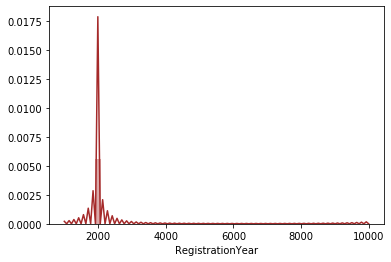

In [8]:
ax = sns.distplot(autos_cor['RegistrationYear'],
                  kde_kws={'color':COLOR},
                  hist_kws={'color':COLOR});
ax.set(xlabel='RegistrationYear')
plt.show()

<div align="justify"> <i> Есть аномальные значения и 1000 и 10000, чего быть не может.<br>
C помощью диаграмм размаха оценим границы значений в столбце 'RegistrationYear'.

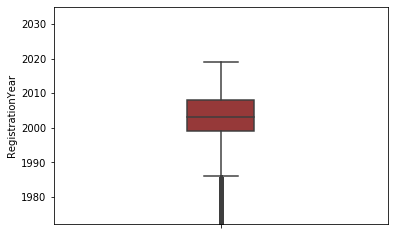

In [9]:
ax = sns.boxplot(y=autos_cor['RegistrationYear'], width=0.2, color=COLOR)
ax.set(ylim=get_range(autos_cor['RegistrationYear'], 3))
plt.show()

<div align="justify"> <i> Сейчас 2020 год, соотвественно значения выше являются ошибочными. По диаграмме размаха нижняя граница ~1985.  Скорей всего бизнес-модель рассчитана только на массовые авто. Не будем использовать ретромашины в модели, т.к. не будем ими торговать. Посмотрим сколько таких значений от начального числа всех машин.

In [10]:
len(autos_cor[(autos_cor['RegistrationYear']<1984)|(autos_cor['RegistrationYear']>2020)])/len(autos)*100

1.454416159427038

<div align="justify"> <i> Меньше 1.5 %. Пока заменим их на np.NaN.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   349215 non-null  float64       
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  NotRepaired        283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  PostalCode         354369 non-null  int64   

None

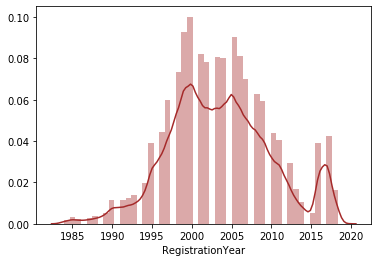

In [11]:
autos_cor.loc[(autos_cor['RegistrationYear']<1984)|(autos_cor['RegistrationYear']>2020), ['RegistrationYear']] = np.NaN
display(autos_cor.info())

ax = sns.distplot(autos_cor[autos_cor['RegistrationYear'].notnull()]['RegistrationYear'],
                  kde_kws={'color':COLOR},
                  hist_kws={'color':COLOR});
ax.set(xlabel='RegistrationYear')
plt.show()

<div align="justify"> <i> В данных явная бимодальность (три горба). Это значит, что выборка наша - состоит как минимум из трёх однородных выборок. Видно, что есть три средних уровня: в районе 1997, 2006-х и в районе 2016.

<div align="justify"> <i> Рассмотрим распределение в столбце 'Power'.

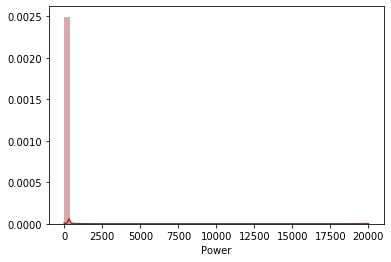

In [12]:
ax = sns.distplot(autos_cor['Power'],
                  kde_kws={'color':COLOR},
                  hist_kws={'color':COLOR});
ax.set(xlabel='Power')
plt.show()

<div align="justify"> <i> Есть аномальные значения и 0 и 20000, чего быть не может.<br>
C помощью диаграмм размаха оценим границы значений в столбце 'Power'.

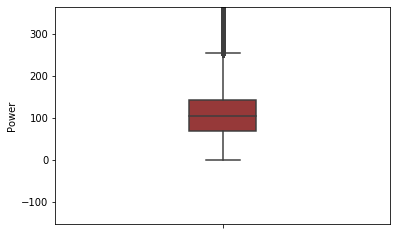

In [13]:
ax = sns.boxplot(y=autos_cor['Power'], width=0.2, color=COLOR)
ax.set(ylim=get_range(autos_cor['Power'], 3))
plt.show()

<div align="justify"> <i> Есть маломощные машины с 4.2 л.с. (Peel P50). Возьмем нижнюю границу 4. По диаграмме размаха верхняя граница ~250. Самый мощный автомобиль 5000 л.с. (Devel Sixteen). Посмотрим сколько значений от начального числа всех машин с верхними границами 250 и 5000.

In [14]:
display(len(autos_cor[(autos_cor['Power']<4)|(autos_cor['Power']>250)])/len(autos)*100)
display(len(autos_cor[(autos_cor['Power']<4)|(autos_cor['Power']>5000)])/len(autos)*100)

13.469293307258818

11.389258089731326

<div align="justify"> <i> Разница небольшая, и компания наверно не торгует поддерженными суперкарами, т.к. максимальная цена 20000. Поэтому оставим значения в интервале от 4 до 250, остальные заменим на np.NaN.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   349215 non-null  float64       
 4   Gearbox            334536 non-null  object        
 5   Power              306638 non-null  float64       
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  NotRepaired        283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  PostalCode         354369 non-null  int64   

None

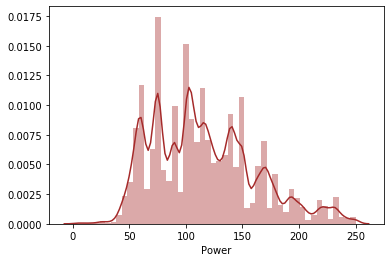

In [15]:
autos_cor.loc[(autos_cor['Power']<4)|(autos_cor['Power']>250), ['Power']] = np.NaN
display(autos_cor.info())

ax = sns.distplot(autos_cor[autos_cor['Power'].notnull()]['Power'],
                  kde_kws={'color':COLOR},
                  hist_kws={'color':COLOR});
ax.set(xlabel='Power')
plt.show()

<div align="justify"> <i> Рассмотрим распределение в столбце 'Price'.

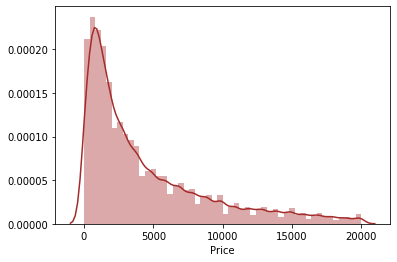

In [16]:
ax = sns.distplot(autos_cor['Price'],
                  kde_kws={'color':COLOR},
                  hist_kws={'color':COLOR});
ax.set(xlabel='Price')
plt.show()

<div align="justify"> <i> Есть аномальные значения равные 0. Посмотрим сколько таких значений.

In [17]:
len(autos_cor[(autos_cor['Price'] == 0)])/len(autos)*100

3.0397692800442475

<div align="justify"> <i> Около 3%. Поскольку это целевой признак и таких строк мало, удалим эти строки.

In [18]:
autos_cor = autos_cor[(autos_cor['Price'] > 0)]
autos_cor.reset_index(drop=True, inplace=True)
autos_cor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343597 entries, 0 to 343596
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        343597 non-null  datetime64[ns]
 1   Price              343597 non-null  int64         
 2   VehicleType        309847 non-null  object        
 3   RegistrationYear   338903 non-null  float64       
 4   Gearbox            326242 non-null  object        
 5   Power              299940 non-null  float64       
 6   Model              326076 non-null  object        
 7   Kilometer          343597 non-null  int64         
 8   RegistrationMonth  343597 non-null  int64         
 9   FuelType           314138 non-null  object        
 10  Brand              343597 non-null  object        
 11  NotRepaired        277731 non-null  object        
 12  DateCreated        343597 non-null  datetime64[ns]
 13  PostalCode         343597 non-null  int64   

<div align="justify"> <i> Рассмотрим распределение в столбце 'Kilometer'.

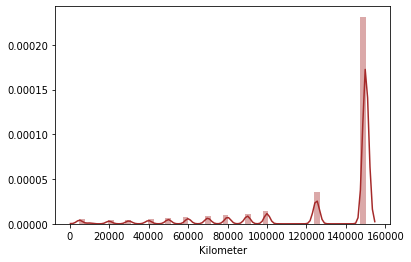

In [19]:
ax = sns.distplot(autos_cor['Kilometer'],
                  kde_kws={'color':COLOR},
                  hist_kws={'color':COLOR});
ax.set(xlabel='Kilometer')
plt.show()

<div align="justify"> <i> Есть значительный выброс равный 150 000 км. Посмотрим сколько таких значений.

In [20]:
len(autos_cor[(autos_cor['Kilometer'] == 150000)])/len(autos)*100

65.05563409891948

<div align="justify"> <i> На сегодняшний день самой распространненной гарантией на мотор является 150 000 км. Поэтому этот пик такой значительный. Оставляем данный столбец без изменений.

<div align="justify"> <i> Посмотрим уникальные значения в этом столбце.

In [21]:
display(autos_cor['Kilometer'].unique())

array([150000, 125000,  90000,  30000,  70000,   5000, 100000,  60000,
        20000,  80000,  50000,  40000,  10000])

<div align="justify"> <i> Колонка 'Kilometer' является категориальным признаком.

<div align="justify"> <i> Рассмотрим распределение в столбце 'RegistrationMonth'.

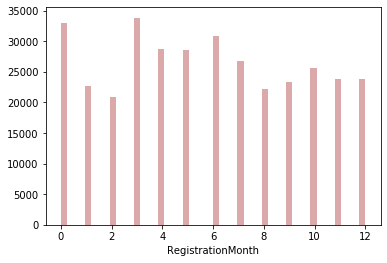

In [22]:
ax = sns.distplot(autos_cor['RegistrationMonth'],
                  kde = False,
                  kde_kws={'color':COLOR},
                  hist_kws={'color':COLOR});
ax.set(xlabel='RegistrationMonth')
plt.show()

<div align="justify"> <i> Есть аномальные значения равные 0. Посмотрим сколько таких значений.

In [23]:
len(autos_cor[(autos_cor['RegistrationMonth'] == 0)])/len(autos)*100

9.278746165719912

<div align="justify"> <i> Около 10%. Пока занулим эти значения.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343597 entries, 0 to 343596
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        343597 non-null  datetime64[ns]
 1   Price              343597 non-null  int64         
 2   VehicleType        309847 non-null  object        
 3   RegistrationYear   338903 non-null  float64       
 4   Gearbox            326242 non-null  object        
 5   Power              299940 non-null  float64       
 6   Model              326076 non-null  object        
 7   Kilometer          343597 non-null  int64         
 8   RegistrationMonth  310716 non-null  float64       
 9   FuelType           314138 non-null  object        
 10  Brand              343597 non-null  object        
 11  NotRepaired        277731 non-null  object        
 12  DateCreated        343597 non-null  datetime64[ns]
 13  PostalCode         343597 non-null  int64   

None

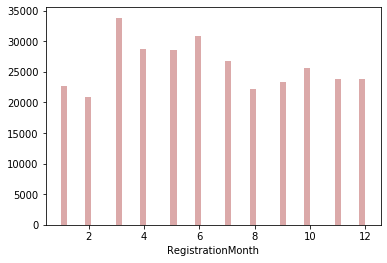

In [24]:
autos_cor.loc[autos_cor['RegistrationMonth']==0, ['RegistrationMonth']] = np.NaN
display(autos_cor.info())

ax = sns.distplot(autos_cor[autos_cor['RegistrationMonth'].notnull()]['RegistrationMonth'],
                  kde = False,
                  hist_kws={'color':COLOR})
ax.set(xlabel='RegistrationMonth')
plt.show()

<div align="justify"> <i> Рассмотрим столбцы 'DateCrawled', 'DateCreated', 'LastSeen'.

In [25]:
autos_cor[['DateCrawled', 'DateCreated', 'LastSeen']].describe()

,DateCrawled,DateCreated,LastSeen
count,343597,343597,343597
unique,265135,109,174543
top,2016-03-24 14:49:47,2016-04-03 00:00:00,2016-04-06 13:45:54
freq,7,13342,16
first,2016-03-05 14:06:22,2014-03-10 00:00:00,2016-03-05 14:15:08
last,2016-04-07 14:36:58,2016-04-07 00:00:00,2016-04-07 14:58:51


<div align="justify"> <i> База за два года с 2014-03-10 по 2016-04-07. Аномальных значений на первый взгляд нет.

In [26]:
autos_cor.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'PostalCode', 'LastSeen'],
      dtype='object')

<div align="justify"> <i> Посмотрим уникальные значения в этом столбцах 'VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired'.

In [27]:
for column in ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']:
    display(autos_cor[column].unique())

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

array(['manual', 'auto', nan], dtype=object)

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'other', 'c4', 'civic',
       'transporter', 'punto', 'e_klasse', 'clio', 'kadett', 'kangoo',
       'one', 'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8',
       'jetta', 'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156',
       'escort', 'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia',
       'combo', 'focus', 'tt', 'corsa', 'a6', 'jazz', 'omega', 'slk',
       '7er', '80', '147', '100', 'z_reihe', 'sportage', 'sorento', 'v40',
       'ibiza', 'mustang', 'eos', 'touran', 'getz', 'a3', 'almera',
       'megane', 'lupo', 'r19', 'zafira', 'caddy', 'mondeo', 'cordoba',
       'colt', 'impreza', 'vectra', 'berlingo', 'tiguan', 'i_reihe',
       'espace', 'sharan', '6_reihe', 'panda', 'up', 'seicento', 'ceed',
       '5_reihe', 'yeti', 'octavia', 'mii', 'rx_reihe', '6er', 'modus',
     

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'chrysler', 'jaguar', 'daewoo', 'porsche',
       'rover', 'saab', 'land_rover', 'lada'], dtype=object)

array([nan, 'yes', 'no'], dtype=object)

<div align="justify"> <i> В столбцах 'VehicleType', 'Gearbox', 'FuelType', 'Brand', 'NotRepaired' все хорошо и понятно. В столбце 'Model' очень много значений. Возможно придется исключить 'Model' из features для модели или упростить этот признак.

## Заполнение пустых значений <a name="step2_2"></a>

<div align="justify"> <i> Посмотрим сколько у нас всего значений строк с пропущенными значениями.

In [28]:
(autos_cor.shape[0] - autos_cor.dropna().shape[0])/len(autos_cor)

0.35888846526599477

<div align="justify"> <i> В категориальных признаках есть пропуски. Эти пропуски заполнить практически невозможно. Оставаим их, библитеки CatBoost и LightGBM расценивают их как отдельную категорию.<br>
Остались пропуски в столбцах 'RegistrationYear', 'Power' и 'RegistrationMonth'. 'RegistrationMonth' заполнять не будем, так как у нас, есть 'RegistrationYear' и цена будет зависеть не от месяца, а от года автомобиля. Заполним 'RegistrationYear' медианными значениями.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343597 entries, 0 to 343596
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        343597 non-null  datetime64[ns]
 1   Price              343597 non-null  int64         
 2   VehicleType        309847 non-null  object        
 3   RegistrationYear   343597 non-null  float64       
 4   Gearbox            326242 non-null  object        
 5   Power              299940 non-null  float64       
 6   Model              326076 non-null  object        
 7   Kilometer          343597 non-null  int64         
 8   RegistrationMonth  310716 non-null  float64       
 9   FuelType           314138 non-null  object        
 10  Brand              343597 non-null  object        
 11  NotRepaired        277731 non-null  object        
 12  DateCreated        343597 non-null  datetime64[ns]
 13  PostalCode         343597 non-null  int64   

None

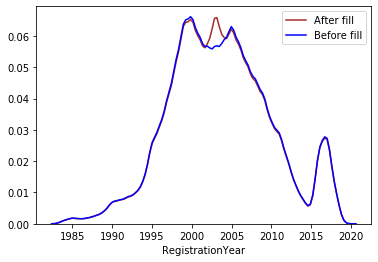

In [29]:
registrationYear_old = autos_cor[autos_cor['RegistrationYear'].notnull()]['RegistrationYear'].values

autos_cor.loc[autos_cor['RegistrationYear'].isnull(), ['RegistrationYear']] = autos_cor['RegistrationYear'].median()
display(autos_cor.info())

ax = sns.distplot(autos_cor['RegistrationYear'],
                  kde_kws={'color':COLOR},
                  hist=False,
                  label='After fill')

ax = sns.distplot(registrationYear_old,
                  kde_kws={'color':'blue'},
                  hist=False,
                  label='Before fill') 

ax.set(xlabel='RegistrationYear')
plt.show()

<div align="justify"> <i> Остались пропуски в столбце 'Power'. Заполним его медианным значением в зависимости от типа кузова.

In [30]:
# для этого создаем словарь из сгруппированных по кузову медианных значений мощности автомобиля
powers_median = dict(autos_cor[autos_cor['VehicleType'].notnull()].groupby(['VehicleType'])['Power'].median())
powers_median

{'bus': 116.0,
 'convertible': 125.0,
 'coupe': 147.0,
 'other': 100.5,
 'sedan': 120.0,
 'small': 68.0,
 'suv': 150.0,
 'wagon': 136.0}

<div align="justify"> <i> Добавим в словарь median, для случая когда неизвестен кузов.

In [31]:
powers_median['median'] = autos_cor['Power'].median()
powers_median

{'bus': 116.0,
 'convertible': 125.0,
 'coupe': 147.0,
 'other': 100.5,
 'sedan': 120.0,
 'small': 68.0,
 'suv': 150.0,
 'wagon': 136.0,
 'median': 110.0}

<div align="justify"> <i> Напишем функцию fill_pass_power для заполнения пропущенных значений по столбцу 'Power'.

In [32]:
# функция принимает строку таблицы
# возвращает мощность автомобиля
def fill_pass_power(row):
    # проверяем пропущено значение 'Power' или нет
    if pd.isna(row['Power']):
        # проверяем пропущено значение 'VehicleType' или нет
        if pd.isna(row['VehicleType']):
            return powers_median['median']
        else:
            return powers_median[row['VehicleType']]
    else:
        # иначе оставляем как есть
        return row['Power']

<div align="justify"> <i> Заполним пропуски по столбцу 'Power' и посмотрим.

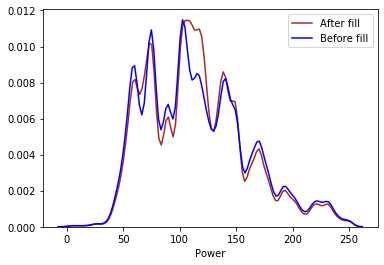

In [33]:
power_old = autos_cor[autos_cor['Power'].notnull()]['Power'].values

autos_cor['Power'] = autos_cor.apply(fill_pass_power, axis=1)
autos_cor['Power'].isnull().sum()

ax = sns.distplot(autos_cor['Power'],
                  kde_kws={'color':COLOR},
                  hist=False,
                  label='After fill')

ax = sns.distplot(power_old,
                  kde_kws={'color':'blue'},
                  hist=False,
                  label='Before fill') 

ax.set(xlabel='Power')
plt.show()

## Создание обучающей и тестовой выборки <a name="step2_3"></a>

<div align="justify"> <i> Уберем из таблицы данные, которые не влияют на цену автомобиля ('DateCrawled', 'RegistrationMonth', 'DateCreated', 'PostalCode', 'LastSeen').

In [34]:
autos_cor = autos_cor.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'PostalCode', 'LastSeen'], axis=1)
autos_cor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343597 entries, 0 to 343596
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             343597 non-null  int64  
 1   VehicleType       309847 non-null  object 
 2   RegistrationYear  343597 non-null  float64
 3   Gearbox           326242 non-null  object 
 4   Power             343597 non-null  float64
 5   Model             326076 non-null  object 
 6   Kilometer         343597 non-null  int64  
 7   FuelType          314138 non-null  object 
 8   Brand             343597 non-null  object 
 9   NotRepaired       277731 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 26.2+ MB


<div align="justify"> <i> Рассмотрим колонку 'Model'. В столбце очень много категориальных значений. Посмотрим можно ли упростить этот признак.

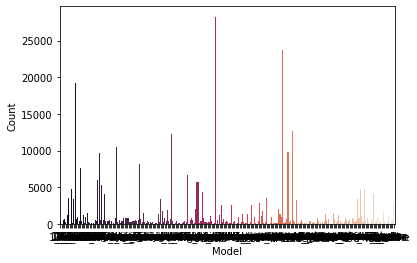

In [35]:
group_model = autos_cor[['Model', 'Power']].groupby('Model').agg(['count'])
group_model.reset_index(level=0, inplace=True)
group_model.columns= ['Model', 'Count']
group_model

ax = sns.barplot(x='Model', y='Count', data=group_model, palette=PALETTE)
#ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

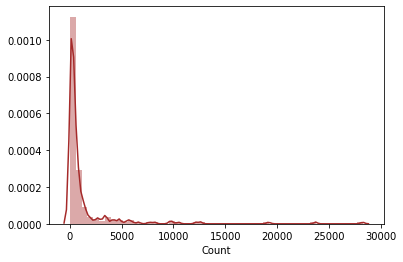

In [36]:
ax = sns.distplot(group_model['Count'],
                  kde_kws={'color':COLOR},
                  hist_kws={'color':COLOR});
ax.set(xlabel='Count')
plt.show()

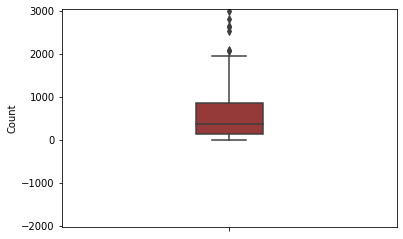

In [37]:
ax = sns.boxplot(y=group_model['Count'], width=0.2, color=COLOR)
ax.set(ylim=get_range(group_model['Count'], 3))
plt.show()

<div align="justify"> <i> Исходя из диаграммы размаха все модели, количество автомобилей которых меньше 2000 переведем в категорию other.

In [38]:
group_model_names = group_model[group_model['Count']<2000]['Model'].unique()
group_model_names

array(['100', '145', '147', '156', '159', '1_reihe', '200', '300c',
       '4_reihe', '500', '5_reihe', '601', '6_reihe', '6er', '7er', '80',
       '850', '90', '900', '9000', '911', 'a1', 'a2', 'a5', 'a8',
       'accord', 'agila', 'alhambra', 'almera', 'altea', 'amarok',
       'antara', 'arosa', 'auris', 'avensis', 'aveo', 'aygo', 'b_klasse',
       'b_max', 'beetle', 'berlingo', 'bora', 'boxster', 'bravo', 'c1',
       'c2', 'c3', 'c4', 'c5', 'c_max', 'c_reihe', 'caddy', 'calibra',
       'captiva', 'carisma', 'carnival', 'cayenne', 'cc', 'ceed',
       'charade', 'cherokee', 'citigo', 'civic', 'cl', 'clk', 'clubman',
       'colt', 'combo', 'cooper', 'cordoba', 'corolla', 'cr_reihe',
       'croma', 'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta',
       'discovery', 'doblo', 'ducato', 'duster', 'elefantino', 'eos',
       'escort', 'espace', 'exeo', 'forester', 'forfour', 'fox',
       'freelander', 'fusion', 'g_klasse', 'galant', 'galaxy', 'getz',
       'gl', 'glk', 'gra

In [39]:
autos_cor.loc[autos_cor['Model'].isin(group_model_names), 'Model'] = 'other'
autos_cor['Model'].unique()

array(['golf', nan, 'other', 'fabia', '3er', '2_reihe', '3_reihe',
       'passat', 'ka', 'polo', 'twingo', 'a_klasse', '5er', 'transporter',
       'punto', 'e_klasse', 'clio', 'fortwo', '1er', 'astra', 'fiesta',
       'c_klasse', 'a4', 'focus', 'corsa', 'a6', 'ibiza', 'touran', 'a3',
       'megane', 'lupo', 'zafira', 'mondeo', 'vectra', 'octavia'],
      dtype=object)

<div align="justify"> <i> Разделим наши данные на обучающую и тестовую выборки согласно общепринятому соотношению 3 к 1.

In [40]:
features_train, features_test, target_train, target_test = train_test_split(autos_cor.drop(['Price'], axis=1), autos_cor['Price'], test_size=0.25, random_state=RANDOM_STATE)

<div align="justify"> <i> Рассмотрим распределения признаков на обучающей и тестовой выборках.

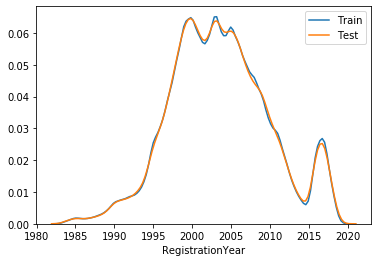

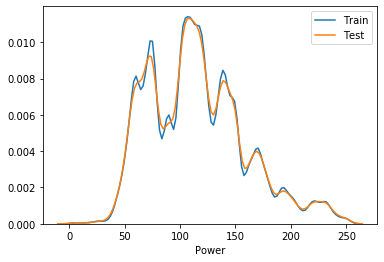

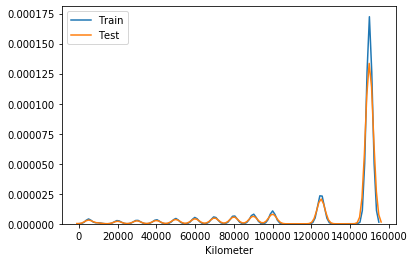

In [41]:
for feature in ['RegistrationYear', 'Power', 'Kilometer']:
    ax = sns.distplot(features_train[feature],
                          hist = False,
                          bins=np.histogram_bin_edges(features_train[feature], bins='sturges'),
                          label='Train')
    
    sns.distplot(features_test[feature],
                          hist = False,
                          bins=np.histogram_bin_edges(features_test[feature], bins='sturges'),
                          label='Test')
    
    ax.set(xlabel=f'{feature}')
    plt.show()

<div align="justify"> <i> Рассмотрим распределения целевого признака на обучающей и тестовой выборках.

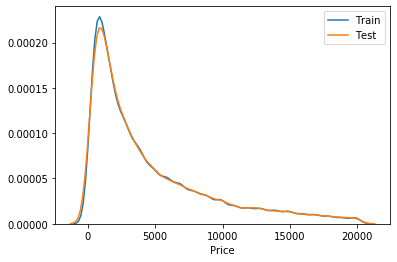

In [42]:
ax = sns.distplot(target_train,
                  hist = False,
                  bins=np.histogram_bin_edges(target_train, bins='sturges'),
                  label='Train')
    
sns.distplot(target_test,
                          hist = False,
                          bins=np.histogram_bin_edges(target_test, bins='sturges'),
                          label='Test')
    
ax.set(xlabel='Price')
plt.show()

<div align='justify'> <i> Подготовим признаки для модели градиентного бустинга из библиотеки CatBoost.<br>
Поскольку CatBoost умеет работать из коробки с категориальными признаками перекодировка не требуется. Однако необходимо заполнить пропуски. Заполним их в тетсовой и тренировочной выборке значениями 'None'.

In [43]:
features_test_cat = features_test.fillna('none')
features_train_cat = features_train.fillna('none')
display(features_train_cat.head())
display(features_test_cat.head())

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
52558,sedan,2009.0,manual,235.0,5er,150000,none,bmw,none
168073,sedan,2005.0,auto,177.0,5er,150000,gasoline,bmw,no
168807,small,2009.0,manual,60.0,other,90000,petrol,fiat,no
178226,coupe,2011.0,manual,147.0,1er,125000,gasoline,bmw,none
21874,sedan,1997.0,manual,60.0,ibiza,150000,petrol,seat,no


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
259347,wagon,2005.0,manual,150.0,other,100000,gasoline,alfa_romeo,no
95943,bus,2003.0,manual,105.0,transporter,150000,gasoline,volkswagen,no
166746,wagon,2004.0,manual,177.0,5er,150000,gasoline,bmw,no
250219,small,1999.0,manual,116.0,focus,150000,petrol,ford,none
134695,wagon,2000.0,manual,170.0,3er,150000,petrol,bmw,no


In [44]:
features_test_cat.columns

Index(['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'NotRepaired'],
      dtype='object')

<div align='justify'> <i> Подготовим признаки для модели градиентного бустинга из библиотеки LightGBM.<br>
Поскольку LightGBM не умеет работать из коробки с категориальными признаками вы полним последовательную перекодировку категориальных признаков.

In [45]:
features_train_light = features_train_cat
features_test_light = features_test_cat

label_encoder = LabelEncoder()

for feature in ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']:
    features_train_light[feature] = label_encoder.fit_transform(features_train_light[feature])
    features_test_light[feature] = label_encoder.fit_transform(features_test_light[feature])

display(features_train_light.head())
display(features_test_light.head())

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
52558,5,2009.0,1,235.0,4,150000,5,2,1
168073,5,2005.0,0,177.0,4,150000,2,2,0
168807,6,2009.0,1,60.0,26,90000,7,9,0
178226,2,2011.0,1,147.0,0,125000,2,2,1
21874,5,1997.0,1,60.0,19,150000,7,30,0


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
259347,8,2005.0,1,150.0,26,100000,2,0,0
95943,0,2003.0,1,105.0,31,150000,2,38,0
166746,8,2004.0,1,177.0,4,150000,2,2,0
250219,6,1999.0,1,116.0,16,150000,7,10,1
134695,8,2000.0,1,170.0,3,150000,7,2,0


### Вывод

<div style = "border:solid #a1b5c9 2px; padding: 20px; background: #f0f0f0" align="justify">
1. Найдены и убраны аномальные значения <br>
2. Заполнены пропуски в числовых признаках. <br>
3. Подготовлены обучающая и тестовая выборки для моделей. <br>  

# 3. Обучение моделей <a name="step3"></a>

<div align='justify'> <i> Исследуем модель градиентного бустинга из библиотеки CatBoost и попытаемся подобрать гиперпарметры этой модели для достижения лучших показателей.<br>
Предварительно укажем какие признаки являются категориальными.

In [46]:
cat_features = features_train.columns[features_train.dtypes == 'object']
cat_features

Index(['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired'], dtype='object')

<div align='justify'> <i> Рассмотрим сначала модель с гиперпараметрами по умолчанию.

In [47]:
model_cat_default = CatBoostRegressor(random_state=RANDOM_STATE)

%time model_cat_default.fit(features_train_cat, target_train, cat_features=cat_features) 

0:	learn: 4429.4721910	total: 1.05s	remaining: 17m 27s
1:	learn: 4348.5934938	total: 2.05s	remaining: 17m 5s
2:	learn: 4271.6010835	total: 2.94s	remaining: 16m 18s
3:	learn: 4196.8372275	total: 3.75s	remaining: 15m 32s
4:	learn: 4125.4927120	total: 4.74s	remaining: 15m 43s
5:	learn: 4056.4291645	total: 5.55s	remaining: 15m 19s
6:	learn: 3990.1292158	total: 6.54s	remaining: 15m 27s
7:	learn: 3925.7800400	total: 7.34s	remaining: 15m 10s
8:	learn: 3863.4263653	total: 8.24s	remaining: 15m 7s
9:	learn: 3804.4471283	total: 9.14s	remaining: 15m 5s
10:	learn: 3748.4739493	total: 9.95s	remaining: 14m 54s
11:	learn: 3694.0396946	total: 10.8s	remaining: 14m 52s
12:	learn: 3642.3194319	total: 11.7s	remaining: 14m 51s
13:	learn: 3593.2670152	total: 12.6s	remaining: 14m 50s
14:	learn: 3544.8364954	total: 13.6s	remaining: 14m 55s
15:	learn: 3499.0825516	total: 14.4s	remaining: 14m 48s
16:	learn: 3454.7471115	total: 15.4s	remaining: 14m 52s
17:	learn: 3412.6018663	total: 16.3s	remaining: 14m 51s
18:	l

In [48]:
%time model_cat_predictions = model_cat_default.predict(features_train_cat)

CPU times: user 2.15 s, sys: 24.3 ms, total: 2.18 s
Wall time: 2.2 s


In [49]:
print(f'RMSE = {mean_squared_error(target_train, model_cat_predictions)**0.5}')
print(f'R2 = {r2_score(target_train, model_cat_predictions)}')

RMSE = 1816.522829907474
R2 = 0.8379788266615493


<div align='justify'> <i> Подберем гиперпараметры для модели градиентного бустинга из библиотеки CatBoost.

In [50]:
model = CatBoostRegressor(random_state=RANDOM_STATE)

model_params = {"iterations":[100, 200, 300],
                "depth":[4, 6, 10],
               'learning_rate':[0.03, 0.1]}

grid = GridSearchCV(model, model_params , cv=3, n_jobs=-1, verbose=True)

In [51]:
"""
grid.fit(features_train_cat, target_train)
print(grid.best_params_)
print(grid.best_score_)
"""

'\ngrid.fit(features_train_cat, target_train)\nprint(grid.best_params_)\nprint(grid.best_score_)\n'

<div style = "border:solid #a1b5c9 2px; padding: 20px; background: #f0f0f0" align="justify"> Лучшие параметры модели: iterations = 300, depth = 10, learning_rate = 0.1.<br>  R2 = 0.8470166971356263.

In [52]:
model_cat_optimus = CatBoostRegressor(random_state=RANDOM_STATE, iterations = 300,  depth=10, learning_rate=0.1)

%time model_cat_optimus.fit(features_train_cat, target_train, cat_features=cat_features)

0:	learn: 4207.7086258	total: 1.89s	remaining: 9m 25s
1:	learn: 3927.0870395	total: 3.6s	remaining: 8m 55s
2:	learn: 3682.0201304	total: 5.2s	remaining: 8m 34s
3:	learn: 3467.7838517	total: 6.99s	remaining: 8m 36s
4:	learn: 3284.0253909	total: 8.6s	remaining: 8m 27s
5:	learn: 3122.2527105	total: 10.4s	remaining: 8m 29s
6:	learn: 2982.4255045	total: 12.1s	remaining: 8m 25s
7:	learn: 2863.7931241	total: 13.6s	remaining: 8m 15s
8:	learn: 2757.0922470	total: 15.3s	remaining: 8m 14s
9:	learn: 2662.5229376	total: 16.9s	remaining: 8m 9s
10:	learn: 2578.8508299	total: 18.5s	remaining: 8m 5s
11:	learn: 2502.2968879	total: 20.2s	remaining: 8m 4s
12:	learn: 2439.0626180	total: 21.8s	remaining: 8m
13:	learn: 2386.6527863	total: 23.6s	remaining: 8m 1s
14:	learn: 2341.1100186	total: 25s	remaining: 7m 54s
15:	learn: 2298.0292391	total: 26.6s	remaining: 7m 51s
16:	learn: 2262.2714754	total: 28.3s	remaining: 7m 50s
17:	learn: 2228.0737864	total: 29.9s	remaining: 7m 47s
18:	learn: 2200.1172388	total: 31

In [53]:
%time model_cat_predictions = model_cat_optimus.predict(features_train_cat)

CPU times: user 2.17 s, sys: 65.4 ms, total: 2.24 s
Wall time: 3.11 s


In [54]:
print(f'RMSE = {mean_squared_error(target_train, model_cat_predictions)**0.5}')
print(f'R2 = {r2_score(target_train, model_cat_predictions)}')

RMSE = 1657.88683903434
R2 = 0.8650416313166691


<div align='justify'> <i> Исследуем модель градиентного бустинга из библиотеки LightGBM и попытаемся подобрать гиперпарметры этой модели для достижения лучших показателей.

In [55]:
model_light_default = LGBMRegressor(random_state=RANDOM_STATE)

%time model_light_default.fit(features_train_light, target_train)

CPU times: user 4min 46s, sys: 0 ns, total: 4min 46s
Wall time: 5min 33s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=12345, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [56]:
%time model_light_predictions = model_light_default.predict(features_train_light)

CPU times: user 2.62 s, sys: 0 ns, total: 2.62 s
Wall time: 3.38 s


In [57]:
print(f'RMSE = {mean_squared_error(target_train, model_light_predictions)**0.5}')
print(f'R2 = {r2_score(target_train, model_light_predictions)}')

RMSE = 1852.5669917324062
R2 = 0.8314852596500356


<div align='justify'> <i> Подберем гиперпараметры для модели градиентного бустинга из библиотеки LightGBM.

In [58]:
model = LGBMRegressor(random_state=RANDOM_STATE)

model_params = {'n_estimators' : range(50, 200, 50),
                'num_leaves': range(21, 41, 10), 
                'min_data_in_leaf': range(25, 75, 25)}

grid = GridSearchCV(model, model_params , cv=3, n_jobs=-1, verbose=True)

In [59]:
"""
grid.fit(features_train_light, target_train)
print(grid.best_params_)
print(grid.best_score_)
"""

'\ngrid.fit(features_train_light, target_train)\nprint(grid.best_params_)\nprint(grid.best_score_)\n'

<div style = "border:solid #a1b5c9 2px; padding: 20px; background: #f0f0f0" align="justify"> Лучшие параметры модели: n_estimators = 150, num_leaves = 31, min_data_in_leaf = 25.<br>
R2 = 0.8349256388569116.

In [60]:
model_light_optimus = LGBMRegressor(random_state=RANDOM_STATE, n_estimators=150, num_leaves = 31, min_data_in_leaf = 25)

%time model_light_optimus.fit(features_train_light, target_train)

CPU times: user 1min 9s, sys: 0 ns, total: 1min 9s
Wall time: 1min 20s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=25,
              min_split_gain=0.0, n_estimators=150, n_jobs=-1, num_leaves=31,
              objective=None, random_state=12345, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [61]:
%time model_light_predictions = model_light_default.predict(features_train_light)

CPU times: user 2.54 s, sys: 0 ns, total: 2.54 s
Wall time: 2.59 s


In [62]:
print(f'RMSE = {mean_squared_error(target_train, model_light_predictions)**0.5}')
print(f'R2 = {r2_score(target_train, model_light_predictions)}')

RMSE = 1852.5669917324062
R2 = 0.8314852596500356


<div style = "border:solid #a1b5c9 2px; padding: 20px; background: #f0f0f0" align="justify"> Лучшие результаты показала модель градиентного бустинга из библиотеки CatBoost cо следующими гиперпарметрами: iterations = 300,  depth=10, learning_rate=0.1.

# 4. Анализ моделей <a name="step4"></a>

<div align="justify"> <i> Проверим модели на тестовой выборке.<br>
Сначала модель градиентного бустинга из библиотеки CatBoost c гиперпарметрами по умолчанию.

In [63]:
%time model_cat_predictions = model_cat_default.predict(features_test_cat)

CPU times: user 743 ms, sys: 0 ns, total: 743 ms
Wall time: 787 ms


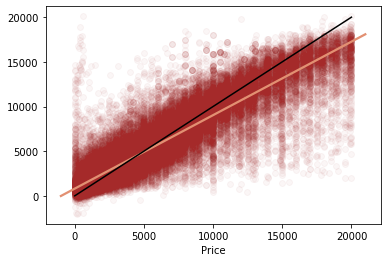

RMSE = 1839.4545471785893
R2 = 0.8344960291095656


In [64]:
sns.regplot(x=target_test, y=model_cat_predictions, scatter_kws={'alpha':0.04}, line_kws={"color": COLOR_LINE}, color=COLOR)
arrange = [target_test.min(), target_test.max()]
sns.lineplot(x=arrange, y=arrange, color='black')

plt.show()

rmse_CatBoost_default = mean_squared_error(target_test, model_cat_predictions)**0.5
r2_CatBoost_default = r2_score(target_test, model_cat_predictions)
print(f'RMSE = {rmse_CatBoost_default}')
print(f'R2 = {r2_CatBoost_default}')

<div align="justify"> <i> Протестируем модель градиентного бустинга из библиотеки CatBoost c подобранными гиперпарметрами.

In [65]:
%time model_cat_predictions = model_cat_optimus.predict(features_test_cat)

CPU times: user 719 ms, sys: 28.5 ms, total: 748 ms
Wall time: 703 ms


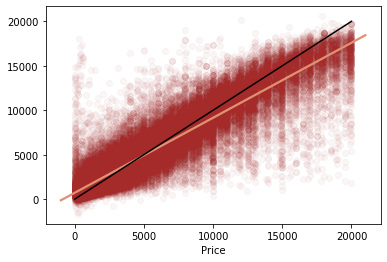

RMSE = 1737.3403809163492
R2 = 0.8523613299211751


In [66]:
sns.regplot(x=target_test, y=model_cat_predictions, scatter_kws={'alpha':0.04}, line_kws={"color": COLOR_LINE}, color=COLOR)
arrange = [target_test.min(), target_test.max()]
sns.lineplot(x=arrange, y=arrange, color='black')

plt.show()

rmse_CatBoost_optimus = mean_squared_error(target_test, model_cat_predictions)**0.5
r2_CatBoost_optimus = r2_score(target_test, model_cat_predictions)
print(f'RMSE = {rmse_CatBoost_optimus}')
print(f'R2 = {r2_CatBoost_optimus}')

<div align="justify"> <i> Проверим модель градиентного бустинга из библиотеки LightGBM.

In [67]:
%time model_light_predictions = model_light_default.predict(features_test_light)

CPU times: user 861 ms, sys: 0 ns, total: 861 ms
Wall time: 832 ms


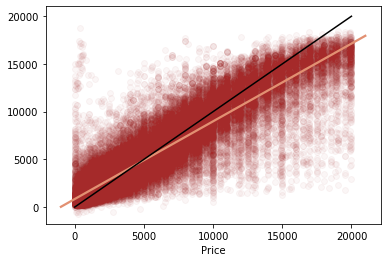

RMSE = 1874.7089956651275
R2 = 0.8280912339557494


In [68]:
sns.regplot(x=target_test, y=model_light_predictions, scatter_kws={'alpha':0.04}, line_kws={"color": COLOR_LINE}, color=COLOR)
arrange = [target_test.min(), target_test.max()]
sns.lineplot(x=arrange, y=arrange, color='black')

plt.show()

rmse_LightGBM_default = mean_squared_error(target_test, model_light_predictions)**0.5
r2_LightGBM_default = r2_score(target_test, model_light_predictions)
print(f'RMSE = {rmse_LightGBM_default}')
print(f'R2 = {r2_LightGBM_default}')

<div align="justify"> <i> Протестируем модель градиентного бустинга из библиотеки LightGBM c подобранными гиперпарметрами.

In [69]:
%time model_light_predictions = model_light_optimus.predict(features_test_light)

CPU times: user 1.39 s, sys: 0 ns, total: 1.39 s
Wall time: 1.39 s


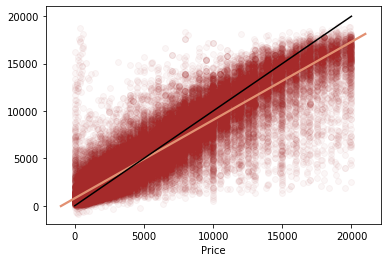

RMSE = 1826.906922784801
R2 = 0.8367462600216138


In [70]:
sns.regplot(x=target_test, y=model_light_predictions, scatter_kws={'alpha':0.04}, line_kws={"color": COLOR_LINE}, color=COLOR)
arrange = [target_test.min(), target_test.max()]
sns.lineplot(x=arrange, y=arrange, color='black')

plt.show()

rmse_LightGBM_optimus = mean_squared_error(target_test, model_light_predictions)**0.5
r2_LightGBM_optimus = r2_score(target_test, model_light_predictions)
print(f'RMSE = {rmse_LightGBM_optimus}')
print(f'R2 = {r2_LightGBM_optimus}')

<div align='justify'> <i> Найдем метрики для среднего значения на тестовой выборке.<br>

In [71]:
mean_predictions = [target_train.mean()]*len(features_test)

rmse_mean = mean_squared_error(target_test, mean_predictions)**0.5
r2_mean = r2_score(target_test, mean_predictions)
print(f'RMSE = {rmse_mean}')
print(f'R2 = {r2_mean}')

RMSE = 4521.524784833311
R2 = -2.9446664684407153e-07


<div align="justify"> <i> Сопоставим итоговые RSME, полученные по модели градиентного бустинга из библиотек CatBoost и LightGBM, с RSME по среднему значению, и определим на сколько лучше модели предсказывают по сравнению со средним значением.

In [72]:
percent_list = [100, rmse_mean/rmse_CatBoost_default*100, rmse_mean/rmse_CatBoost_optimus*100, rmse_mean/rmse_LightGBM_default*100, rmse_mean/rmse_LightGBM_optimus*100]
model_names = ['Mean', 'CatBoost_default', 'CatBoost_optimus', 'LightGBM_default', 'LightGBM_optimus']

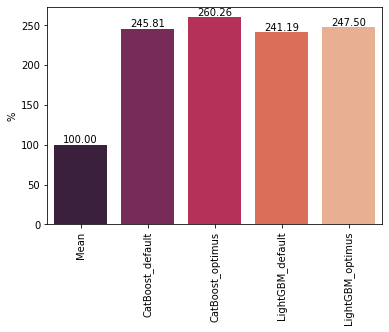

In [73]:
ax = sns.barplot(x=model_names, y=percent_list, palette=PALETTE)
ax.set(ylabel='%')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

for patch in ax.patches:
    h = patch.get_height()
    ax.text(patch.get_x() + patch.get_width() / 2., h, f"{h:.{2}f}", ha='center', va='bottom')

plt.show()

<div style = "border:solid #a1b5c9 2px; padding: 20px; background: #f0f0f0" align="justify"> Модель градиентного бустинга из библиотеки CatBoost с подобранными гиперпарметрами на тестовой выборке также показала наилучший результат.<br>
Сервис по продаже автомобилей с пробегом «Не бит, не крашен» должен быть доволен, т.к. итоговая модель предсказывает цену автомобиля точнее модели по среднему по параметру RMSE на ~150%.
<br>По времени предсказания итоговая модель также оказалась лучше.

<div align="justify"> <i> Оценим какие факторы больше всего влияют на цену подержаного автомобиля для выбранной модели.

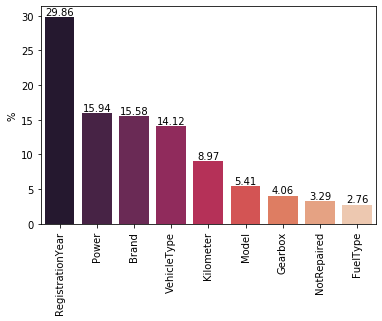

In [74]:
feature_importances = dict(zip(features_train.columns, model_cat_optimus.feature_importances_))
feature_importances = dict(sorted(feature_importances.items(), key=lambda x: x[1], reverse=True))

ax = sns.barplot(x=list(feature_importances.keys()), y=list(feature_importances.values()), palette=PALETTE)
ax.set(ylabel='%')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

for patch in ax.patches:
    h = patch.get_height()
    ax.text(patch.get_x() + patch.get_width() / 2., h, f"{h:.{2}f}", ha='center', va='bottom')

plt.show()

<div style = "border:solid #a1b5c9 2px; padding: 20px; background: #f0f0f0" align="justify"> Больше всего на цену автомобиля влияет год выпуска автомобиля с весом 29.86%. Как только машина выехала из салона, она уже теряет в цена, не гворя уже о поддержаных автомобилях. Далее три фактора с близкими весами ~15% (мощность, бренд и тип автомобиля) и километраж с ~9%. Все остальные факторы имеют близкие к 5% или менее веса.

# 5. Общий вывод <a name="step5"></a>

<div style = "border:solid #a1b5c9 2px; padding: 20px; background: #f0f0f0" align="justify">
1. При выгрузке данных были обнаружены пропуски, не соответствия данных форматам, аномальные значения<br>
2. Выполнена подготовка данных. <br>
2.1. Найдены и убраны аномальные значения <br>
2.2. Заполнены пропуски в числовых признаках. <br>
2.3. Подготовлены обучающая и тестовая выборки для моделей. <br>  
3. Рассмотрены различные модели для предсказания рыночной стоимости поддержаных автомобилей.<br>
3.1. При дефолтных настройках модели, чуть выше RMSE у модели из библиотеки CatBoost. Однако она проигрывает по времени модели из библиотеки LightGBM. <br>
3.2. Лучшая модель по метрикам модель из библиотеки CatBoost со следующими гиперпарметрами: iterations = 300,  depth=10, learning_rate=0.1.<br>
3.3. Выбранная модель также показала лучший результат на тестовой выборке. Итоговая модель модель предсказывает цену автомобиля точнее модели по среднему по параметру RMSE на ~150%. По времени предсказания итоговая модель также оказалась лучше.<br>
3.4. Больше всего на цену автомобиля влияет год выпуска автомобиля с весом 29.86%. Как только машина выехала из салона, она уже теряет в цена, не гворя уже о поддержаных автомобилях. Далее три фактора с близкими весами ~15% (мощность, бренд и тип автомобиля) и километраж с ~9%. Все остальные факторы имеют близкие к 5% или менее веса.